# PyTorch Neural Net

In [1]:
import os
from glob import glob
import random
import time
import pickle
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

#to import from src directory
import sys
sys.path.append('./src/')
from main import *
from TorchModelHelper import *

In [2]:
# some constants

#random numbers rn
NUM_TRAIN = 9000
NUM_VAL = 1000
NUM_TEST = 10000

NUM_CLASSES = 10
IMG_W = 64
IMG_H = 64

RS = 22 # random seed

In [3]:
# FOR LOADING THE DATA FOR THE FIRST TIME
# COMMENT OUT ONCE PICKLE FILES ARE SAVED

#Xtrain, Ytrain = load_train(IMG_W, IMG_H)
#Xtest = load_test(IMG_W, IMG_H)

#with open('./train_array.pkl', 'wb') as fid:
    #pickle.dump((Xtrain, Ytrain), fid) #stores a tuple
#with open('./test_array.pkl', 'wb') as fid:
    #pickle.dump(Xtest, fid)

In [4]:
# load in the image data from the pickle files

with open('./train_array.pkl', 'rb') as fid:
    X_train,Y_train = pickle.load(fid)
with open('./test_array.pkl', 'rb') as fid:
    X_test = pickle.load(fid)
print("Xtrain shape:", X_train.shape)
print("Ytrain shape:", Y_train.shape)
print("Xtest shape:", X_test.shape)

Xtrain shape: (22424, 64, 64, 3)
Ytrain shape: (22424,)
Xtest shape: (79726, 64, 64, 3)


In [5]:
# split training data into train/validation split
Xtrain, Xval, Ytrain, Yval = train_test_split(X_train, Y_train, test_size=0.30, random_state=RS)
print(Xtrain.shape, Ytrain.shape, Xval.shape, Yval.shape, sep='\n')

(15696, 64, 64, 3)
(15696,)
(6728, 64, 64, 3)
(6728,)


In [6]:
#convert arrays to torch.Tensor
Xtrain = np.transpose(Xtrain, (0, 3, 1, 2))
Xtrain = torch.from_numpy(Xtrain)

Xval = torch.from_numpy(Xval)
Xval = np.transpose(Xval, (0, 3, 1, 2))

Ytrain = torch.from_numpy(Ytrain)

Yval = torch.from_numpy(Yval)

# Data Exploration

(22424, 3)


<Figure size 1440x1440 with 0 Axes>

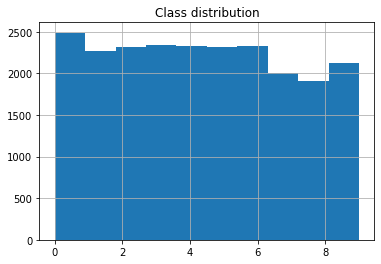

In [7]:
dataset = pd.read_csv('data/driver_imgs_list.csv')
print(dataset.shape)

# Plotting class distribution
dataset['class_type'] = dataset['classname'].str.extract('(\d)',expand=False).astype(np.float)
plt.figure(figsize = (20,20))
dataset.hist('class_type', alpha=1, layout=(1,1), bins=10)
plt.title('Class distribution')
plt.show()

# Pytorch Neural Net

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import timeit

In [9]:
torch.cuda.is_available()

True

In [10]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.reshape(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [11]:
if torch.cuda.is_available():
    DTYPE = torch.cuda.FloatTensor #GPU type
else:
    DTYPE = torch.FloatTensor #CPU type

In [12]:
model_base = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=7, stride=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2, stride=2),
    Flatten(),
    nn.Linear(53824,1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024, 10),
)

model = model_base.type(DTYPE)

loss_fn = nn.CrossEntropyLoss().type(DTYPE)
optimizer = optim.RMSprop(model.parameters(), lr = 1e-3)

## Train model

In [15]:
torch.cuda.random.manual_seed(2468)
model.apply(reset)
train(model, loss_fn, optimizer, num_epochs=3)

Starting epoch 1 / 3
t = 100, loss = 0.7995
t = 200, loss = 0.2210
t = 300, loss = 0.1363
Starting epoch 2 / 3
t = 100, loss = 0.0879
t = 200, loss = 0.0145
t = 300, loss = 1.0213
Starting epoch 3 / 3
t = 100, loss = 0.0035
t = 200, loss = 0.0017
t = 300, loss = 0.1058


In [18]:
check_accuracy(model, Xval, Yval, Xval.shape[0])

tensor(6544)
Got 6544 / 6700 correct (97.67)


97.67164179104478

In [17]:
# run on the test set for final accuracy

#check_accuracy(model, Xtest)